In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings(action='ignore')

from utils import preprocessing as my_prep
from utils import regression as my_reg
from utils import evaluate as my_eval

# Data load

In [5]:
data_new = pd.read_csv("./data/seoul_preprocessed2_y_nextquarter.csv")
data_new.shape

(173745, 30)

### 분기별로 분할

In [6]:
quarters = ['2017_1', '2017_2', '2017_3', '2017_4', '2018_1', '2018_2', '2018_3', '2018_4', '2019_1', '2019_2', '2019_3']
datas = {}
for q in quarters:
    year, quarter = map(int, q.split("_"))
    
    bool_year = data_new.기준_년_코드==year
    bool_quarter = data_new.기준_분기_코드==quarter
    datas[q] = data_new[bool_year & bool_quarter] 
    
for key in datas.keys():
    print(key, datas[key].shape)

2017_1 (15795, 30)
2017_2 (15795, 30)
2017_3 (15795, 30)
2017_4 (15795, 30)
2018_1 (15795, 30)
2018_2 (15795, 30)
2018_3 (15795, 30)
2018_4 (15795, 30)
2019_1 (15795, 30)
2019_2 (15795, 30)
2019_3 (15795, 30)


# Split train, validate, test

In [57]:
trainfiles = ['2017_1', '2017_2', '2017_3', '2017_4', '2018_1', '2018_2', '2018_3']
validatefiles = []
testfiles = ['2018_4', '2019_1', '2019_2', '2019_3']  # 2019_1, 2019_2, 2019_3, 2019_4 맞추기

train, validate, test = my_prep.split_train_val_test_by_file(datas, trainfiles, validatefiles, testfiles, category='편의점')
print(train.shape, validate.shape, test.shape)

[train] 2017_1 : (1147, 30), accumulate : (1147, 30)
[train] 2017_2 : (1147, 30), accumulate : (2294, 30)
[train] 2017_3 : (1147, 30), accumulate : (3441, 30)
[train] 2017_4 : (1147, 30), accumulate : (4588, 30)
[train] 2018_1 : (1147, 30), accumulate : (5735, 30)
[train] 2018_2 : (1147, 30), accumulate : (6882, 30)
[train] 2018_3 : (1147, 30), accumulate : (8029, 30)
[test] 2018_4 : (1147, 30), accumulate : (1147, 30)
[test] 2019_1 : (1147, 30), accumulate : (2294, 30)
[test] 2019_2 : (1147, 30), accumulate : (3441, 30)
[test] 2019_3 : (1147, 30), accumulate : (4588, 30)
(8029, 30) (0, 0) (4588, 30)


### split x, y

In [58]:
#x_header = [x for x in train.columns if '연령대' in x and x.find('연령대')==0]
x_header = [x for x in train.columns if '남성연령대' in x or '여성연령대' in x]
y_header = ['다음분기_매출_금액']
print(x_header, y_header)

['남성연령대_10_유동인_수', '남성연령대_20_유동인_수', '남성연령대_30_유동인_수', '남성연령대_40_유동인_수', '남성연령대_50_유동인_수', '남성연령대_60_유동인_수', '여성연령대_10_유동인_수', '여성연령대_20_유동인_수', '여성연령대_30_유동인_수', '여성연령대_40_유동인_수', '여성연령대_50_유동인_수', '여성연령대_60_유동인_수'] ['다음분기_매출_금액']


In [59]:
x_train, y_train = my_prep.split_xy(train, x_header, y_header)
# x_validate, y_validate = my_prep.split_xy(validate, x_header, y_header)
x_test, y_test = my_prep.split_xy(test, x_header, y_header)

print('train', x_train.shape, y_train.shape)
# print('validate', x_validate, y_validate)
print('test', x_test.shape, y_test.shape)

train (8029, 12) (8029, 1)
test (4588, 12) (4588, 1)


### for random split

In [12]:
x_train = np.concatenate((x_train, x_test))
y_train = np.concatenate((y_train, y_test))
print('train', x_train.shape, y_train.shape)

train (12617, 12) (12617, 1)


In [13]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.3)
print('train', x_train.shape, y_train.shape)
print('test', x_test.shape, y_test.shape)

train (8831, 12) (8831, 1)
test (3786, 12) (3786, 1)


# Normalize, Augmentation

### Normalize

In [60]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = StandardScaler().fit(x_train)
x_train_scale = scaler.transform(x_train)
x_test_scale = scaler.transform(x_test)

scaler_y = StandardScaler().fit(y_train)
y_train_scale = scaler_y.transform(y_train)
y_test_scale = scaler_y.transform(y_test)

print('train', x_train_scale.shape, y_train_scale.shape)
print('test', x_test_scale.shape, y_test_scale.shape)

train (8029, 12) (8029, 1)
test (4588, 12) (4588, 1)


In [61]:
pd.DataFrame(y_test_scale).describe()

,0
count,4588.000000
mean,-0.080009
std,0.979572
min,-0.685552
25%,-0.488525
50%,-0.333356
75%,-0.046047
max,19.612056


### Correlation coefficient

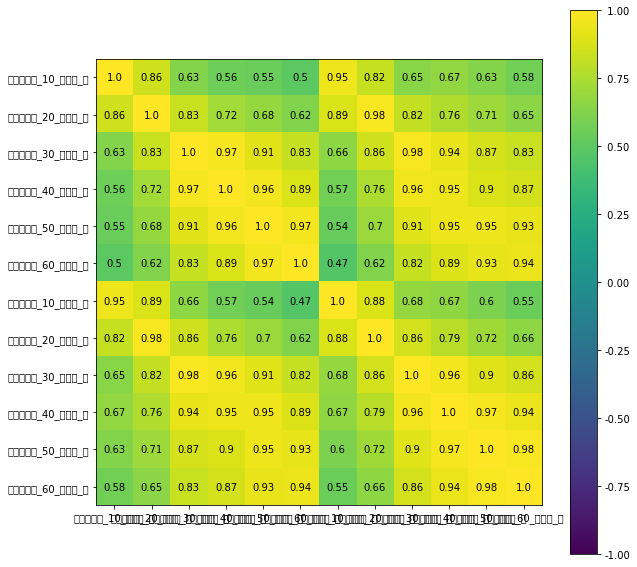

In [62]:
my_eval.visualize_CorrelCoeff_heatmap(x_train_scale, x_header, figsize=(10, 10))

# Training

In [18]:
model_LR = my_reg.get_model_LinearRegression(x_train_scale, y_train_scale)
model_Elastic = my_reg.get_model_ElasticNet(x_train_scale, y_train_scale)
model_SVR = my_reg.get_model_SVR(x_train_scale, y_train_scale)

# hidden_layers = [512, 256, 4]
# model_MLPRegression = my_reg.get_model_MLPRegression(
#     x_train_scale, y_train_scale, 
#     hidden_layers=hidden_layers,
#     max_iter=5000,
#     alpha=0.0001,
#     random_state=42
# )

In [19]:
model_LR.coef_

array([[-0.11883552,  0.05474173,  0.48886179,  0.29746466,  0.12861218,
        -0.33582613,  0.05728521,  0.03421091,  0.08288307,  0.0024362 ,
        -0.09882321, -0.03134328]])

### Keras (Tensorflow 2.2.0)

In [63]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
print(tf.__version__)

2.2.0


In [71]:
def build_model(input_shape):
    model = keras.Sequential([
    layers.Dense(24, activation='relu', input_shape=input_shape),
    layers.Dense(12, activation='relu'),
    #layers.Dense(6, activation='relu'),
    layers.Dense(1)
    ])

#     optimizer = tf.keras.optimizers.RMSprop(0.001)

#     model.compile(loss='mse',
#                 optimizer=optimizer,
#                 metrics=['mae', 'mse'])
    return model

In [72]:
model_MLPRegression = build_model(input_shape=[x_train_scale.shape[1]])
model_MLPRegression.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_26 (Dense)             (None, 24)                312       
_________________________________________________________________
dense_27 (Dense)             (None, 12)                300       
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 13        
Total params: 625
Trainable params: 625
Non-trainable params: 0
_________________________________________________________________


In [53]:
example_batch = x_train_scale[:10]
example_result = model_MLPRegression.predict(example_batch)
example_result

array([[ 0.05326957],
       [-0.07376826],
       [ 0.04048261],
       [-0.54206973],
       [-1.0730051 ],
       [ 0.03961685],
       [-0.03041074],
       [-0.0100368 ],
       [ 0.00619482],
       [-0.04791471]], dtype=float32)

In [56]:
loss_object = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.Adam()

train_loss = keras.metrics.Mean(name='train_loss')
test_loss = keras.metrics.Mean(name='test_loss')

@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        predictions = model_MLPRegression(x)
        loss = loss_object(y, predictions)
        gradients = tape.gradient(loss, model_MLPRegression.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model_MLPRegression.trainable_variables))

        train_loss(loss)
        
        
@tf.function
def test_step(x, y):
    predictions = model_MLPRegression(x)
    t_loss = loss_object(y, predictions)

    test_loss(t_loss)

    
EPOCHS = 1000
BATCH_SIZE = 64
ITER_SIZE = x_train_scale.shape[0]//BATCH_SIZE
print('EPOCH %d, BATCH_SIZE %d, ITER_SIZE %d' %(EPOCHS, BATCH_SIZE, ITER_SIZE))
history = {'train_loss':[], 'test_loss':[]}
for epoch in range(EPOCHS):
    #print('epoch', epoch,'...')
    
    for it in range(ITER_SIZE):
        
        ix_start = BATCH_SIZE*it
        ix_end = min(ix_start+BATCH_SIZE, x_train_scale.shape[0])
        
#         if it%100==0:
#             print('iterate %d  start:%d  end:%d' %(it, ix_start, ix_end))
        
        # train batch
        train_step(x_train_scale[ix_start:ix_end, :], y_train_scale[ix_start:ix_end, :])
        
    # validate all
    #print('validate...')
    for ix in range(x_test_scale.shape[0]):
        test_step(x_test_scale[ix, :].reshape(1, 12), y_test_scale[ix, :].reshape(1, 1))


    #if epoch%50==0:
    template = '에포크: {}, 손실: {}, 테스트 손실: {}'
    print (template.format(epoch+1,train_loss.result(),test_loss.result()))
    history['train_loss'].append(train_loss.result())
    history['test_loss'].append(test_loss.result())

EPOCH 1000, BATCH_SIZE 64, ITER_SIZE 137
에포크: 1, 손실: 0.7593951225280762, 테스트 손실: 0.9533647298812866
에포크: 2, 손실: 0.7533808350563049, 테스트 손실: 0.9469529390335083
에포크: 3, 손실: 0.7476055026054382, 테스트 손실: 0.9408705830574036
에포크: 4, 손실: 0.7421209216117859, 테스트 손실: 0.935208261013031
에포크: 5, 손실: 0.7369225025177002, 테스트 손실: 0.9297154545783997
에포크: 6, 손실: 0.7319858074188232, 테스트 손실: 0.9243291020393372
에포크: 7, 손실: 0.7272343039512634, 테스트 손실: 0.9191268086433411
에포크: 8, 손실: 0.722687840461731, 테스트 손실: 0.9141559600830078
에포크: 9, 손실: 0.718360185623169, 테스트 손실: 0.9094244241714478
에포크: 10, 손실: 0.714232861995697, 테스트 손실: 0.9048824906349182
에포크: 11, 손실: 0.7102799415588379, 테스트 손실: 0.9005117416381836
에포크: 12, 손실: 0.7064858675003052, 테스트 손실: 0.8963197469711304
에포크: 13, 손실: 0.7028452157974243, 테스트 손실: 0.89232337474823
에포크: 14, 손실: 0.6993704438209534, 테스트 손실: 0.8884841203689575
에포크: 15, 손실: 0.6960335969924927, 테스트 손실: 0.8847340941429138
에포크: 16, 손실: 0.6928074359893799, 테스트 손실: 0.8811114430427551
에포크: 17, 손실: 0

KeyboardInterrupt: 

In [55]:
model_MLPRegression(x_test_scale[0, :].reshape(1, 12))

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.8153252]], dtype=float32)>

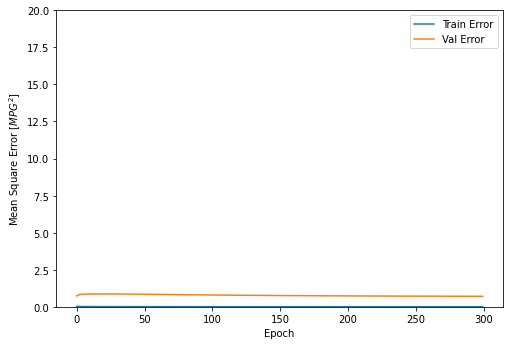

In [52]:
def plot_history(history):

    plt.figure(figsize=(8,12))

    plt.subplot(2,1,1)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(history['train_loss'],
           label='Train Error')
    plt.plot(history['test_loss'],
           label = 'Val Error')
    plt.ylim([0,20])
    plt.legend()
    plt.show()

plot_history(history)

# Evaluate

### Linear Regression

------- evaluate Linear Regression -------
RMSE : 0.827774
R2 : 0.511666
----------------------------


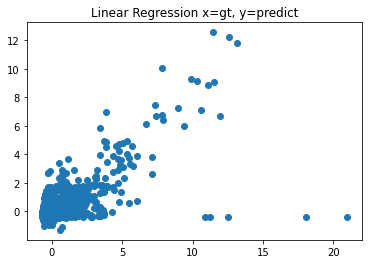

In [53]:
my_eval.eval_regression(y_test_scale, model_LR.predict(x_test_scale), model_name='Linear Regression')

### ElasticNet

------- evaluate ElasticNet -------
RMSE : 1.098710
R2 : 0.139681
----------------------------


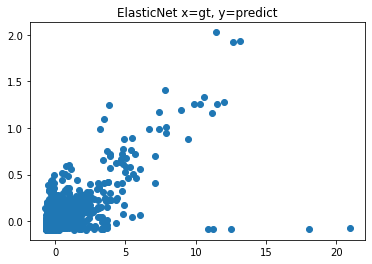

In [54]:
my_eval.eval_regression(y_test_scale, model_Elastic.predict(x_test_scale), model_name='ElasticNet')

### SVR

------- evaluate SVM Regression -------
RMSE : 1948478007.256517
R2 : -0.374628
----------------------------


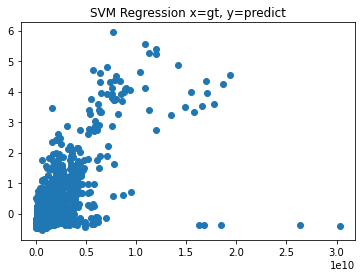

In [55]:
my_eval.eval_regression(y_test, model_SVR.predict(x_test_scale), model_name='SVM Regression')

# MLP Regressoin

------- evaluate MLP Regression -------
RMSE : 1948478007.804822
R2 : -0.374628
----------------------------


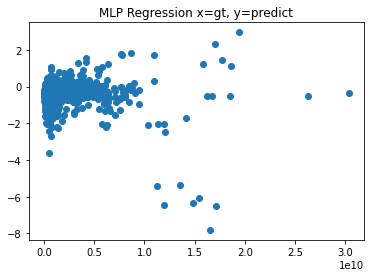

In [56]:
my_eval.eval_regression(y_test, model_MLPRegression.predict(x_test_scale), model_name='MLP Regression')

# 오차 계산

In [57]:
def evaluate_error(y_gt, y_pred, title=''):
    li_error = []
    for i in zip(y_gt, y_pred):
        error = (abs(i[0]-i[1])/i[0])
        li_error.append(error)

    print(sum(li_error), y_pred.shape[0])
    print('평균 오차 %.lf%%' %(np.mean(li_error)))
    print('최대 오차 %.lf%%' %(np.max(li_error)))
    print('최소 오차 %.lf%%' %(np.min(li_error)))

    #li_error.sort(reverse=True)
    #print('Top 10 오차 %s' %(li_error[:10]))
    plt.plot(li_error)
    plt.title(title)

[3786.00000484] 3786
평균 오차 1%
최대 오차 1%
최소 오차 1%


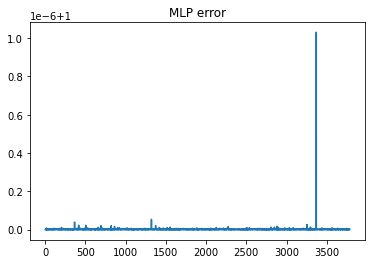

In [58]:
#### normed
# y_pred_scale_MLP = model_MLPRegression.predict(x_test_scale)
# y_pred_MLP = scaler_y.inverse_transform(y_pred_scale_MLP)

# evaluate_error(y_test[:, 0], y_pred_MLP, title='MLP error')

#### non-normed
y_pred_MLP = model_MLPRegression.predict(x_test_scale)

evaluate_error(y_test[:, 0], y_pred_MLP, title='MLP error')

[7167.67410254] 3786
평균 오차 2%
최대 오차 2854%
최소 오차 0%


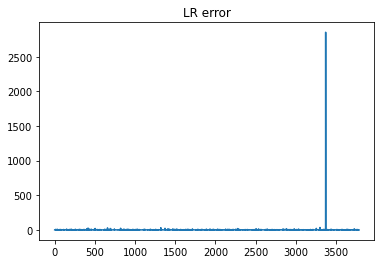

In [59]:
y_pred_scale_LR = model_LR.predict(x_test_scale)
y_pred_LR = scaler_y.inverse_transform(y_pred_scale_LR)

evaluate_error(y_test[:, 0], y_pred_LR, title="LR error")

9528.514009179786 3786
평균 오차 3%
최대 오차 3346%
최소 오차 0%


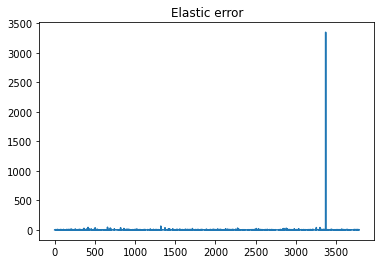

In [60]:
y_pred_scale_Elastic = model_Elastic.predict(x_test_scale)
y_pred_Elastic = scaler_y.inverse_transform(y_pred_scale_Elastic)

evaluate_error(y_test[:, 0], y_pred_Elastic, title='Elastic error')

# Conclusion

##### 정답 값이 너무 비슷? 몇명만 너무 큼? 
##### 큰 의미가 없나?

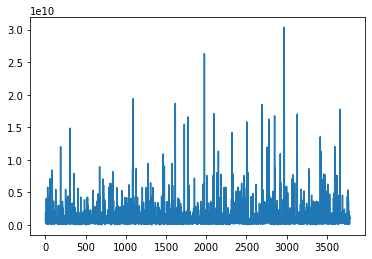

In [61]:
plt.plot(y_test)

In [ ]:
print('MLP', int(scaler_y.inverse_transform([-0.02651767])))
print('LR', int(scaler_y.inverse_transform([-0.06412931])))
#print('SVR', int(scaler_y.inverse_transform([-0.02651767])))
print('Elastic', int(scaler_y.inverse_transform([4.09963574e-10])))    #
print('ground truth', y_test[0, 0])

# TODO

1) 전처리  
- 가중치부여    

2) 차원축소  
 - wrapper, PCA    

3) 증분  
 - 회귀 증분?    

4) 모델 
 - LGBM, MLP monitoring  

5) 학습/검증 분할
 - random
 - k-fold(train,validate)/test
 - sequence  
 
6) 분석, 결론
 - MSE, R2
 - 오차
 - 시각화 (지도?)

버릴건 버려야